In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics,model_selection,linear_model,preprocessing, ensemble
from sklearn.model_selection import GridSearchCV as grid_search
import xgboost as xgb
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
data=pd.read_csv('data/train.csv')
test=pd.read_csv('data/test.csv')

In [53]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Status,Age_bin,Fare_fill,Cabin_cat,Pclass_ed,Relatives_bin,SibSp_cat,Parch_cat,Age_scale,Fare_fill_scale
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,Mr,midle_age,7.2500,U,Third,One,One,Single,-0.584263,-0.502445
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,Mrs,midle_age,71.2833,C,First,One,One,Single,0.621822,0.786845
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,Miss,midle_age,7.9250,U,Third,Single,Single,Single,-0.282742,-0.488854
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,Mrs,midle_age,53.1000,C,First,One,One,Single,0.395681,0.420730
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,Mr,midle_age,8.0500,U,Third,Single,Single,Single,0.395681,-0.486337


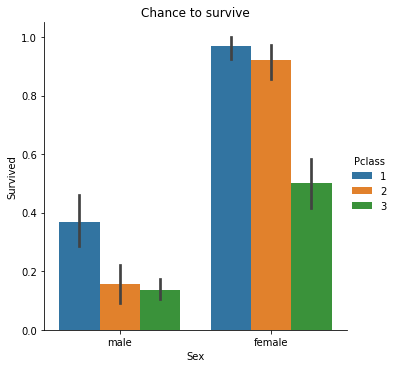

In [5]:
sns.catplot(x="Sex", y="Survived", hue="Pclass", kind="bar", data=data);
pyplot.title('Chance to survive')
pyplot.show()

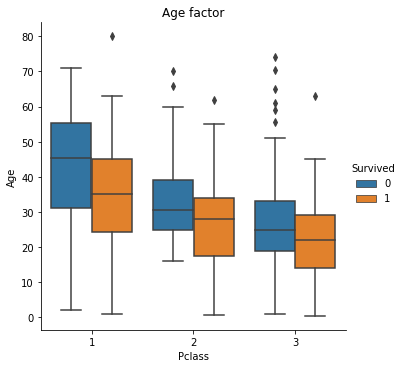

In [6]:
sns.catplot(x="Pclass", y="Age", kind="box", hue="Survived",data=data);
pyplot.title('Age factor')
pyplot.show()

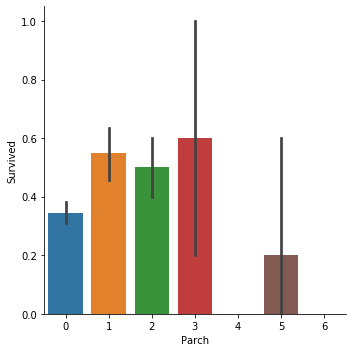

In [20]:
# #of parents / children aboard the Titanic
sns.catplot(x="Parch", y="Survived", kind="bar", data=data);

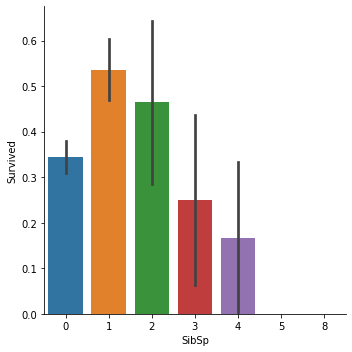

In [7]:
# #of siblings / spouses aboard the Titanic
sns.catplot(x="SibSp", y="Survived", kind="bar", data=data);

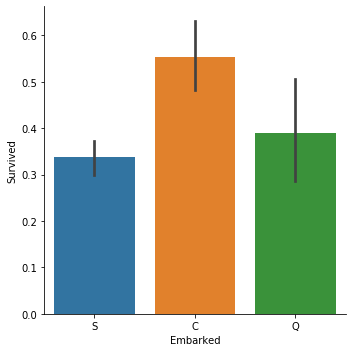

In [8]:
# Port of Embarkation: C = Cherbourg, Q = Queenstown, S = Southampton
sns.catplot(x="Embarked", y="Survived", kind="bar", data=data);

In [9]:
data['Relatives']=data.SibSp.values+data.Parch.values
test['Relatives']=test.SibSp.values+test.Parch.values
test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Relatives
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,2


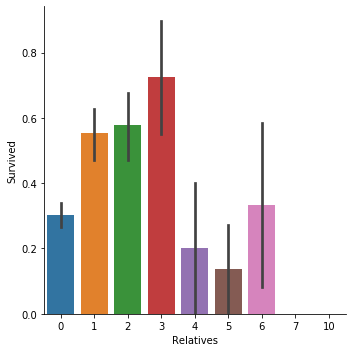

In [10]:
sns.catplot(x="Relatives", y="Survived", kind="bar", data=data);

In [11]:
def change_cat(col,max):
    mass=[]
    for i in col:
        if i<max:
            mass.append(i)
        else:
            mass.append(max)
    return mass
        

In [12]:
data['Relatives_ed']=change_cat(data.Relatives,5)
test['Relatives_ed']=change_cat(test.Relatives,5)
test.head(5)
data['Age_fill']=data.Age.fillna(value=np.round(data.Age.median(),2))
#data['Age_bin']=pd.cut(data.Age_fill,[0.1,5,10,15,20,40,50,60,110],labels=['yung_1','yung_2','yung_3','yung_4','midle_age','old_3','old_2','very_old'])

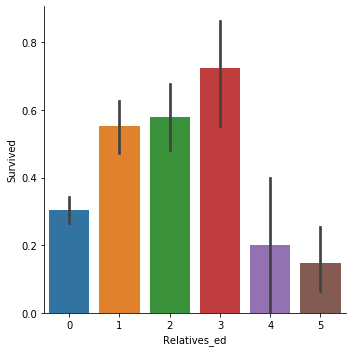

In [13]:
sns.catplot(x="Relatives_ed", y="Survived", kind="bar", data=data);

In [14]:
data['SeconName']=data.Name.apply(lambda x: x.split(',',1)[0])
data['Status']=data.Name.apply(lambda x: x.split(',',1)[1].split('.',1)[0])
test['SecondName']=test.Name.apply(lambda x: x.split(',',1)[0])
test['Status']=test.Name.apply(lambda x: x.split(',',1)[1].split('.',1)[0])
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Relatives,Relatives_ed,SecondName,Status
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,0,Kelly,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1,1,Wilkes,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,0,Myles,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,0,Wirz,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,2,2,Hirvonen,Mrs


In [15]:
s=       {' Capt':       'Officer',
          ' Col':        'Officer',
          ' Major':      'Officer',
          ' Jonkheer':   'Royalty',
          ' Don':        'Royalty',
          ' Sir' :       'Royalty',
          ' Dr':         'Dr',
          ' Rev':        'Rev',
          ' the Countess':   'Royalty',
          ' Dona':       'Royalty',
          ' Mme':        'Mrs',
          ' Mlle':       'Miss',
          ' Ms':         'Mrs',
          ' Mr' :        'Mr',
          ' Mrs' :       'Mrs',
          ' Miss' :      'Miss',
          ' Master' :    'Master',
          ' Lady' :      'Royalty'
                    }

In [16]:
for i,j in s.items():
    data.loc[data.Status==i,'Status']=j
    test.loc[test.Status==i,'Status']=j
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Relatives,Relatives_ed,SecondName,Status
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,0,Kelly,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1,1,Wilkes,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,0,Myles,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,0,Wirz,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,2,2,Hirvonen,Mrs


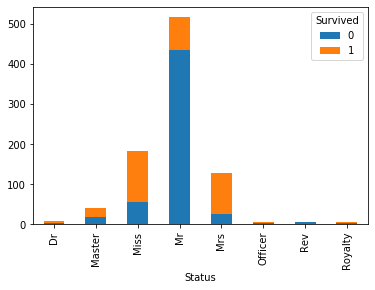

In [17]:
data_pivot_status=data.pivot_table('PassengerId','Status','Survived',aggfunc='count')
data_pivot_status.plot(kind='bar',stacked=True)

In [18]:
# NA in dataset
data.isnull().sum()

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age             177
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin           687
Embarked          2
Relatives         0
Relatives_ed      0
Age_fill          0
SeconName         0
Status            0
dtype: int64

In [19]:
data['Age_fill']=data.groupby(['Sex','Status'])['Age'].apply(lambda x: x.fillna(mean(x)))
data['Age_bin']=pd.cut(data.Age_fill,[0.1,5,10,15,20,40,50,60,110],labels=['yung_1','yung_2','yung_3','yung_4','midle_age','old_3','old_2','very_old'])
test['Age_fill']=data.groupby(['Sex','Status'])['Age'].apply(lambda x: x.fillna(mean(x)))
test['Age_bin']=pd.cut(test.Age_fill,[0.1,5,10,15,20,40,50,60,110],
                      labels=['yung_1','yung_2','yung_3','yung_4','midle_age','old_3','old_2','very_old'])
test.head(6)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Relatives,Relatives_ed,SecondName,Status,Age_fill,Age_bin
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,0,Kelly,Mr,22.00000,midle_age
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1,1,Wilkes,Mrs,38.00000,midle_age
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,0,Myles,Mr,26.00000,midle_age
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,0,Wirz,Mr,35.00000,midle_age
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,2,2,Hirvonen,Mrs,35.00000,midle_age
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S,0,0,Svensson,Mr,32.36809,midle_age


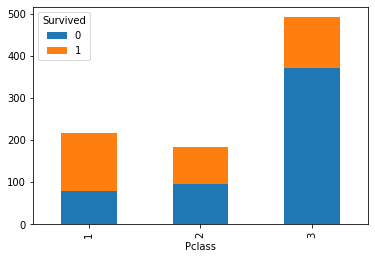

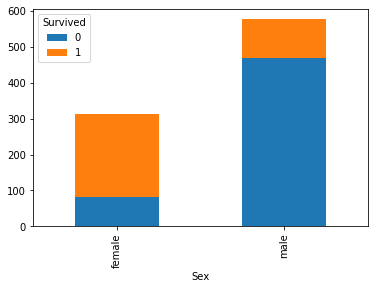

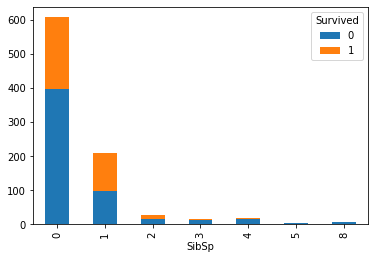

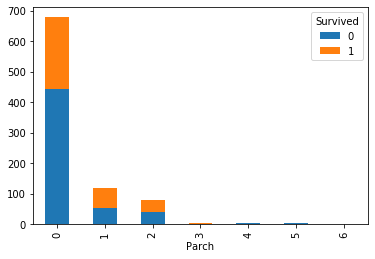

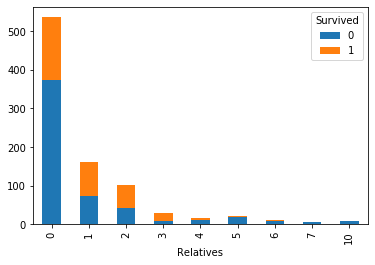

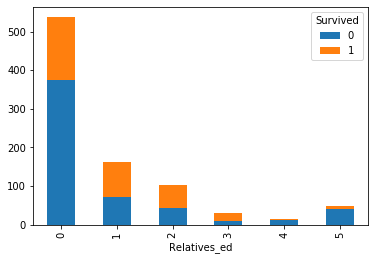

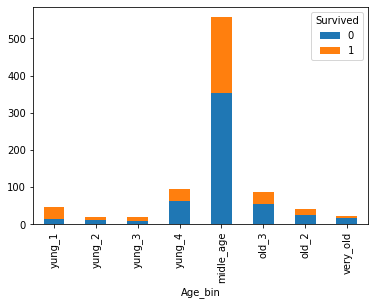

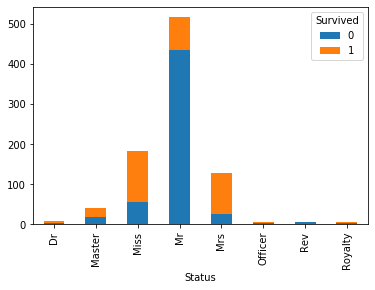

In [20]:
data_pivot_pclass=data.pivot_table('PassengerId','Pclass','Survived',aggfunc='count')
data_pivot_pclass.plot(kind='bar',stacked=True)
data_pivot_Sex=data.pivot_table('PassengerId','Sex','Survived',aggfunc='count')
data_pivot_Sex.plot(kind='bar',stacked=True)
data_pivot_SibSp=data.pivot_table('PassengerId','SibSp','Survived',aggfunc='count')
data_pivot_SibSp.plot(kind='bar',stacked=True)
data_pivot_Parch=data.pivot_table('PassengerId','Parch','Survived',aggfunc='count')
data_pivot_Parch.plot(kind='bar',stacked=True)
data_pivot_Relatives=data.pivot_table('PassengerId','Relatives','Survived',aggfunc='count')
data_pivot_Relatives.plot(kind='bar',stacked=True)
data_pivot_Relatives_ed=data.pivot_table('PassengerId','Relatives_ed','Survived',aggfunc='count')
data_pivot_Relatives_ed.plot(kind='bar',stacked=True)
data_pivot_age_bins=data.pivot_table('PassengerId','Age_bin','Survived',aggfunc='count')
data_pivot_age_bins.plot(kind='bar',stacked=True)
data_pivot_status=data.pivot_table('PassengerId','Status','Survived',aggfunc='count')
data_pivot_status.plot(kind='bar',stacked=True)

In [22]:
# data[['Age_fill']].plot(kind='hist',)
# test.Age_fill.plot(kind='hist')

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Relatives,Relatives_ed,SecondName,Status,Age_fill,Age_bin,Fare_fill
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,0,Kelly,Mr,22.0,midle_age,7.8292
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1,1,Wilkes,Mrs,38.0,midle_age,7.0000
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,0,Myles,Mr,26.0,midle_age,9.6875
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,0,Wirz,Mr,35.0,midle_age,8.6625
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,2,2,Hirvonen,Mrs,35.0,midle_age,12.2875


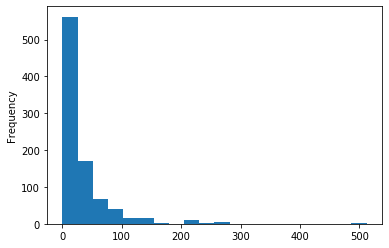

In [23]:
data.Fare.plot(kind='hist',bins=20)
data.Fare.describe()
test['Fare_fill']=test.groupby(['Pclass'])['Fare'].apply(lambda x: x.fillna(mean(x)))
data['Fare_fill']=data.Fare.values
test.head()

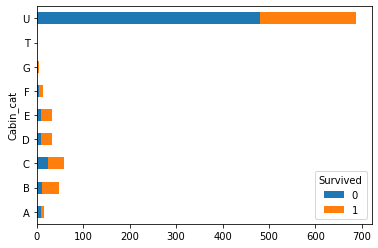

In [24]:
data.Cabin=data.Cabin.fillna('Unknow')
data['Cabin_cat']=data.Cabin.apply(lambda x: x[0])
test.Cabin=test.Cabin.fillna('Unknow')
test['Cabin_cat']=test.Cabin.apply(lambda x: x[0])

data_pivot_cabin_cat=data.pivot_table('PassengerId','Cabin_cat','Survived',aggfunc='count')
data_pivot_cabin_cat.plot(kind='barh',stacked=True)
    

In [25]:
data.loc[data.Cabin_cat=='T','Cabin_cat']='U'
#print test.Cabin_cat.value_counts()
data.Cabin_cat.value_counts()


U    688
C     59
B     47
D     33
E     32
A     15
F     13
G      4
Name: Cabin_cat, dtype: int64

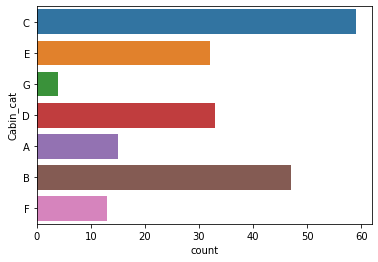

In [26]:
import seaborn
seaborn.countplot(y='Cabin_cat',data=data[data.Cabin_cat!='U'])

/home/vasylcf/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


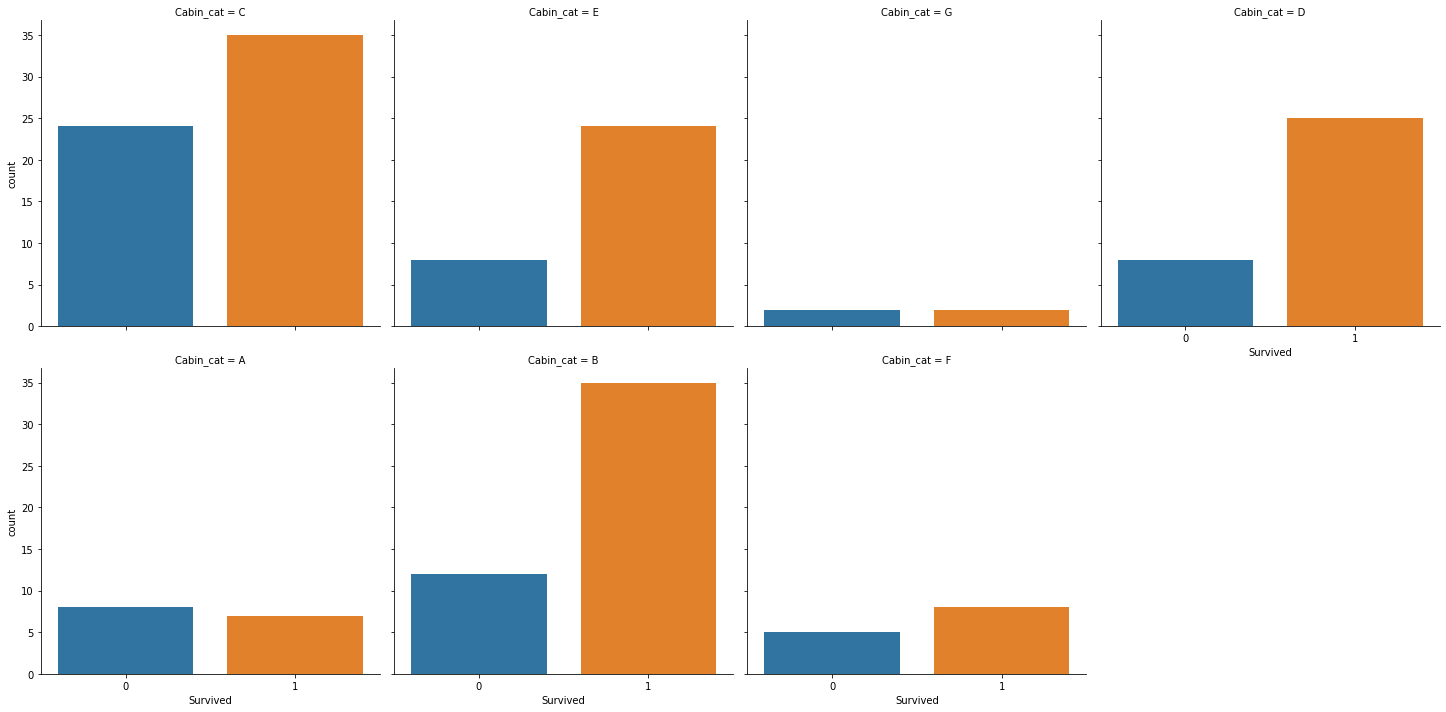

In [27]:
#seaborn.factorplot('Survived',col='Cabin_cat',data=data.Cabin_cat[data.Cabin_cat<>'U'],kind='count')
seaborn.factorplot('Survived',col='Cabin_cat',data=data[data.Cabin_cat!='U'],kind='count',col_wrap=4)

In [28]:
#emb=data.Embarked.value_counts()
#emb.argmax()
data.Embarked=data.Embarked.fillna(data.Embarked.value_counts().argmax())
data.Embarked.isnull().any()

/home/vasylcf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


False

In [29]:
pcls={1:'First',
     2:'Second',
     3:'Third'}
data['Pclass_ed']=data.Pclass.values
test['Pclass_ed']=test.Pclass.values
for i,j in pcls.items():
    data.loc[data.Pclass_ed==i,'Pclass_ed']=j
    test.loc[test.Pclass_ed==i,'Pclass_ed']=j

In [30]:
relatives_bin={0: 'Single',
              1: 'One',
              2: 'Two',
              3: 'middle',
              4: 'middle',
              5: 'big'}
data['Relatives_bin']=data.Relatives_ed
test['Relatives_bin']=test.Relatives_ed
for i,j in relatives_bin.items():
    data.loc[data['Relatives_bin']==i,'Relatives_bin']=j
    test.loc[test['Relatives_bin']==i,'Relatives_bin']=j
    

In [31]:
data['SibSp_cat']=data.SibSp.values
test['SibSp_cat']=test.SibSp.values
data['Parch_cat']=data.Parch.values
test['Parch_cat']=test.Parch.values
data.loc[data.SibSp>4,'SibSp_cat']=5
test.loc[test.SibSp>4,'SibSp_cat']=5
data.loc[data.Parch>4,'Parch_cat']=5
test.loc[test.Parch>4,'Parch_cat']=5

In [32]:
relation_id={0: 'Single',
              1: 'One',
              2: 'Two',
              3: 'three',
              4: 'four',
              5: 'big',
            }
for i,j in relation_id.items():
    data.loc[data['SibSp']==i,'SibSp_cat']=j
    test.loc[test['SibSp']==i,'SibSp_cat']=j
    data.loc[data['Parch']==i,'Parch_cat']=j
    test.loc[test['Parch']==i,'Parch_cat']=j
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Age_fill,SeconName,Status,Age_bin,Fare_fill,Cabin_cat,Pclass_ed,Relatives_bin,SibSp_cat,Parch_cat
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,22.000000,Braund,Mr,midle_age,7.2500,U,Third,One,One,Single
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,38.000000,Cumings,Mrs,midle_age,71.2833,C,First,One,One,Single
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,26.000000,Heikkinen,Miss,midle_age,7.9250,U,Third,Single,Single,Single
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,35.000000,Futrelle,Mrs,midle_age,53.1000,C,First,One,One,Single
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,35.000000,Allen,Mr,midle_age,8.0500,U,Third,Single,Single,Single
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,...,27.000000,Montvila,Rev,midle_age,13.0000,U,Second,Single,Single,Single
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,...,19.000000,Graham,Miss,yung_4,30.0000,B,First,Single,Single,Single
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,...,21.804054,Johnston,Miss,midle_age,23.4500,U,Third,middle,One,Two
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,...,26.000000,Behr,Mr,midle_age,30.0000,C,First,Single,Single,Single


In [33]:
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Relatives',
       'Relatives_ed', 'Age_fill', 'SeconName', 'Status', 'Age_bin',
       'Fare_fill', 'Cabin_cat', 'Pclass_ed', 'Relatives_bin', 'SibSp_cat',
       'Parch_cat'],
      dtype='object')

In [34]:
# decode categorical features

cat_label=['Sex','Embarked','Status','Pclass_ed','Cabin_cat','SibSp_cat','Parch_cat']
frame_cat=pd.get_dummies(data[cat_label],drop_first=False)
test_cat=pd.get_dummies(test[cat_label],drop_first=False)
test_cat.head()
    
    

,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Status_Dr,Status_Master,Status_Miss,Status_Mr,Status_Mrs,...,SibSp_cat_big,SibSp_cat_four,SibSp_cat_three,Parch_cat_5,Parch_cat_One,Parch_cat_Single,Parch_cat_Two,Parch_cat_big,Parch_cat_four,Parch_cat_three
0,0,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,0,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,0,1,0,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [35]:
scale=preprocessing.StandardScaler()
scale_fare=preprocessing.StandardScaler()
data['Age_scale']=scale.fit_transform(data['Age_fill'].values.reshape(-1,1))
data['Fare_fill_scale']=scale_fare.fit_transform(data['Fare_fill'].values.reshape(-1,1))
test['Age_scale']=scale.fit_transform(test['Age_fill'].values.reshape(-1,1))
test['Fare_fill_scale']=scale_fare.fit_transform(test['Fare_fill'].values.reshape(-1,1))

In [36]:
#Создание чистой выборки для анализа
#'Fare_fill',Age_fill
X=pd.concat((data[['Fare_fill_scale','Age_scale']],frame_cat),axis=1)
T=pd.concat((test[['Fare_fill_scale','Age_scale']],test_cat),axis=1)
T.head()

,Fare_fill_scale,Age_scale,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Status_Dr,Status_Master,Status_Miss,...,SibSp_cat_big,SibSp_cat_four,SibSp_cat_three,Parch_cat_5,Parch_cat_One,Parch_cat_Single,Parch_cat_Two,Parch_cat_big,Parch_cat_four,Parch_cat_three
0,-0.497311,-0.518099,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,-0.512175,0.710919,1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,-0.463999,-0.210844,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,-0.482373,0.480478,0,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,-0.417392,0.480478,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [37]:
#Целевая метка
y=data.Survived

In [38]:
X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,test_size=0.28)

In [39]:
clf_xgb=xgb.XGBClassifier()
clf_xgb.fit(X_train,y_train)
predict=clf_xgb.predict(X_test)
metrics.accuracy_score(y_test,predict)
#print "Precision: ",metrics.precision_score(y_test,predict)
#print "Recall: ",metrics.recall_score(y_test,predict)
#print "ROC AUC: ",metrics.roc_auc_score(y_test,predict)
#print metrics.classification_report(y_test,predict)
#print metrics.confusion_matrix(y_test,predict)

0.816

In [40]:
score=model_selection.cross_val_score(clf_xgb,X_train,y_train,cv=5,scoring='accuracy')
score

array([0.86046512, 0.81395349, 0.796875  , 0.828125  , 0.79527559])

In [41]:
score=model_selection.cross_val_score(clf_xgb,X_train,y_train,cv=5,scoring='precision')
score

array([0.81481481, 0.81818182, 0.79069767, 0.82222222, 0.74509804])

In [42]:
clf_xgb.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)>

In [43]:
# Сетка параметров
clf_xgb.get_params().keys()
params={ 'learning_rate':np.linspace(0.01,0.1,10),
        'n_estimators':np.linspace(10,100,10,dtype='int')
       }
grid_clf=grid_search(clf_xgb,params,cv=3,scoring='accuracy')

In [44]:
grid_clf.fit(X_train,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ]),
                         'n_estimators': array([ 10,  20

In [45]:
grid_clf.best_score_
predict2=grid_clf.best_estimator_.predict(X_test)
print (metrics.classification_report(y_test,predict2))


              precision    recall  f1-score   support

           0       0.85      0.88      0.87       165
           1       0.76      0.69      0.72        85

    accuracy                           0.82       250
   macro avg       0.80      0.79      0.80       250
weighted avg       0.82      0.82      0.82       250



In [46]:

print (grid_clf.best_score_)
print (grid_clf.best_params_)

0.8268330733229329
{'learning_rate': 0.08, 'n_estimators': 100}


In [47]:
clf_linear=linear_model.LogisticRegression(penalty='l1')
clf_linear.fit(X_train,y_train)

/home/vasylcf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [48]:
score=model_selection.cross_val_score(clf_linear,X_train,y_train,cv=5,scoring='accuracy')
print (score.mean())
print (metrics.classification_report(y_test,clf_linear.predict(X_test)))

0.8267394173838735
              precision    recall  f1-score   support

           0       0.86      0.87      0.86       165
           1       0.74      0.72      0.73        85

    accuracy                           0.82       250
   macro avg       0.80      0.80      0.80       250
weighted avg       0.82      0.82      0.82       250



/home/vasylcf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vasylcf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vasylcf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vasylcf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/vasylcf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to '

In [49]:
clf_ridge=linear_model.RidgeClassifier()
clf_ridge.fit(X_train,y_train)
score=model_selection.cross_val_score(clf_ridge,X_train,y_train,scoring='accuracy',cv=5)
print (score)
print (metrics.accuracy_score(y_test,clf_ridge.predict(X_test)))
print (metrics.classification_report(y_test,clf_ridge.predict(X_test)))

[0.82945736 0.81395349 0.796875   0.8125     0.81102362]
0.82
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       165
           1       0.75      0.71      0.73        85

    accuracy                           0.82       250
   macro avg       0.80      0.79      0.80       250
weighted avg       0.82      0.82      0.82       250



In [50]:
pred=pd.DataFrame(grid_clf.best_estimator_.predict(T))
id=test['PassengerId']
final=pd.concat((id,pred),axis=1,ignore_index=True)
matrix=final.values
answ2=pd.DataFrame(matrix,columns=['PassengerId','Survived'])
answ2.to_csv('answer-grid.csv',sep=',',header=True,index=False)

In [51]:
pred=pd.DataFrame(clf_linear.predict(T))
id=test['PassengerId']
final=pd.concat((id,pred),axis=1,ignore_index=True)
matrix=final.values
answ2=pd.DataFrame(matrix,columns=['PassengerId','Survived'])
answ2.to_csv('answer-log.csv',sep=',',header=True,index=False)

In [52]:
#https://www.kaggle.com/c/titanic/submissions